Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = ""
COLLABORATORS = ""

---

# Homework 3: Matrix Transforms

In this homework, we will look at different ways to represent and transform matrices.

### Householder similarity transforms

Suppose we are given a square symmetric matrix $A$.  What sort of algorithm could we use to construct a symmetric tridiagonal matrix $\hat A$ such that
$$ A = Q \hat A Q^T $$
where $Q$ is an orthogonal matrix.
We'll construct such a matrix $Q$ out of elementary reflectors, much like we did in Householder QR.

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
plt.style.use('seaborn')
np.set_printoptions(precision=4)

A = np.random.rand(4, 4)
A = A + A.T # Random symmetric matrix
A

array([[1.4403, 0.7911, 1.0108, 1.1928],
       [0.7911, 1.5731, 0.227 , 1.6522],
       [1.0108, 0.227 , 1.8489, 1.1329],
       [1.1928, 1.6522, 1.1329, 1.2728]])

We'll create a Householder-style reflector matrix for column 0, to introduce zeros below the *tridiagonal*.

In [3]:
def reflector(v):
    return np.eye(len(v)) - 2*np.outer(v, v)

v = A[1:,0].copy()
print(v)
v[0] -= np.linalg.norm(v)
print(v)
v = v / np.linalg.norm(v)
F = reflector(v)
print(F)
Q_0 = block_diag(np.eye(1), F)
Q_0

[0.7911 1.0108 1.1928]
[-0.9611  1.0108  1.1928]
[[ 0.4515  0.5768  0.6807]
 [ 0.5768  0.3934 -0.7159]
 [ 0.6807 -0.7159  0.1551]]


array([[ 1.    ,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.4515,  0.5768,  0.6807],
       [ 0.    ,  0.5768,  0.3934, -0.7159],
       [ 0.    ,  0.6807, -0.7159,  0.1551]])

In [4]:
# Introduce zeros below the tridiagonal in column 0.
Q_0 @ A

array([[ 1.4403e+00,  7.9110e-01,  1.0108e+00,  1.1928e+00],
       [ 1.7522e+00,  1.9659e+00,  1.9402e+00,  2.2659e+00],
       [ 2.2204e-16, -1.8611e-01,  4.7191e-02,  4.8752e-01],
       [ 2.2204e-16,  1.1647e+00, -9.9330e-01,  5.1119e-01]])

In [5]:
# Same in the first row
A_1 = Q_0 @ A @ Q_0
A_1

array([[ 1.4403e+00,  1.7522e+00,  2.2204e-16,  2.2204e-16],
       [ 1.7522e+00,  3.5493e+00,  2.7507e-01,  3.0086e-01],
       [ 2.2204e-16,  2.7507e-01, -4.3781e-01, -8.4837e-02],
       [ 2.2204e-16,  3.0086e-01, -8.4837e-02,  1.5833e+00]])

## Efficiency

In the above, we have computed
$$ A_1 := Q_0 A Q_0 $$
(note that $Q_0 = Q_0^T$) using a very inefficient algorithm.
Instead of creating the dense $n\times n$ reflector $F$ above and then multiplying it at $O(n^3)$ cost, write a function that applies the reflector to a matrix at $O(n^2)$ cost.  Recall that
$$ (I - 2 v v^T) B = B - 2 v (v^T B) $$
and also that
$$ B (I - 2 v v^T) = B - 2 (B v) v^T . $$
Also note that you can take the submatrix all but row 0 using `B[1:]` and all but column 0 using `B[:,1:]`.

In [6]:
def symreflect(A, v):
    """Efficiently compute Q_0 A Q_0 where Q_0 is defined in terms of v.
    """
    B = A.copy() # Make a copy so we don't modify A
    # Modify B by applying reflections.
    # This line applies the reflection on the left, storing the result in-place.
    B[1:] -= 2 * np.outer(v, v @ B[1:])
    # Now you write code to apply a similar reflection on the right.
    B[:,1:] -= 2 * np.outer( B[:,1:] @ v,v)
    block_diag(np.eye(1), B[1:])
    return B

symreflect(A, v)

array([[ 1.4403e+00,  1.7522e+00,  2.2204e-16,  2.2204e-16],
       [ 1.7522e+00,  3.5493e+00,  2.7507e-01,  3.0086e-01],
       [ 2.2204e-16,  2.7507e-01, -4.3781e-01, -8.4837e-02],
       [ 2.2204e-16,  3.0086e-01, -8.4837e-02,  1.5833e+00]])

In [7]:
def symreflect_naive(A, v):
    F = reflector(v)
    Q_0 = block_diag(np.eye(1), F)
    return Q_0 @ A @ Q_0

assert np.allclose(symreflect(A, v), symreflect_naive(A, v))
print('Tests pass')

Tests pass


## Tridiagonalization

Suppose we implement a sequence of transformations $Q_0, Q_1, \dotsc$ to introduce zeros in successive columns and rows.  Then we'll have
\begin{align}
\hat A &= \dotsb Q_2 \Big( Q_1 ( Q_0 A Q_0 ) Q_1 \Big) Q_2 \dotsb \\
&= \underbrace{\dotsb Q_2 Q_1 Q_0}_{Q^T} A \underbrace{Q_0 Q_1 Q_2 \dotsb}_{Q}
\end{align}
which is an orthogonal reduction to symmetric tridiagonal form.

First, we note that the natural way to store $Q$ is as a list of reflector vectors $v$.
To check our results, we'd like to be able to make $Q$ as an explicit matrix.  This function is a near copy of one in the Linear Algebra notebook.

In [8]:
def Q_times_x(V, x):
    """Apply orthogonal matrix Q represented as list of Householder reflectors"""
    y = x.copy()
    for v in reversed(V):
        i = -len(v)
        y[i:] -= 2 * v * (v @ y[i:])
    return y

def Q_as_explicit(V):
    m = len(V[0]) + 1
    Q = np.eye(m)
    for i, col in enumerate(Q.T):
        Q[:,i] = Q_times_x(V, col)
    return Q

In [9]:
def symtridiagonalize(A):
    """Reduce the symmetric matrix A to tridiagonal form using
    orthogonal transformation Q^T A Q.
    """
    B = A.copy()
    n = len(B)
    V = []
    for i in range(n - 2):
        v = B[i+1:,i].copy()
        # Turn v into a normalized vector representing
        # the reflection I - 2 v v^T
        # YOUR CODE HERE
        print(v)
        v[0] -= np.linalg.norm(v)
        print(v)
        v = v / np.linalg.norm(v)
        print(v)
       # raise NotImplementedError()
        B[i:, i:] = symreflect(B[i:, i:], v)
        V.append(v)
    return B, Q_as_explicit(V)

Ahat, Q = symtridiagonalize(A)
print(Ahat) # Symmetric and tridiagonal
print('Error:', np.linalg.norm(Q.T @ A @ Q - Ahat))

[0.7911 1.0108 1.1928]
[-0.9611  1.0108  1.1928]
[-0.5237  0.5507  0.6499]
[0.2751 0.3009]
[-0.1326  0.3009]
[-0.4033  0.9151]
[[ 1.4403e+00  1.7522e+00  2.2204e-16  2.2204e-16]
 [ 1.7522e+00  3.5493e+00  4.0765e-01 -1.6653e-16]
 [ 2.2204e-16  4.0765e-01  5.7853e-01 -1.0141e+00]
 [ 2.2204e-16 -5.5511e-17 -1.0141e+00  5.6694e-01]]
Error: 8.120581339769891e-16


In [10]:
Ahat, Q = symtridiagonalize(A)
np.allclose(A, Q @ Ahat @ Q.T)

[0.7911 1.0108 1.1928]
[-0.9611  1.0108  1.1928]
[-0.5237  0.5507  0.6499]
[0.2751 0.3009]
[-0.1326  0.3009]
[-0.4033  0.9151]


True

## Eigensolvers

This reduction to tridiagonal (or, for non-symmetric matrices, Hessenberg) form is the first step for all modern eigensolvers. Eigensolver algorithms such as the [QR Algorithm for eigenvalues](https://en.wikipedia.org/wiki/QR_algorithm) (not to be confused with QR factorization) are necessarily iterative and those iterations are much less expensive when working with tridiagonal or Hessenberg matrices.

## Low-rank matrix compression

Consider the gravitational force from a star at position $x_1$ acting on a star at position $x_0$,
$$ F_{0,1} = G \frac{m_0 m_1}{\lVert x_1 - x_0 \rVert^3} (x_1 - x_0) $$
where $m_0$ and $m_1$ are the masses of each star respectively.
Suppose we have two galaxies of size $n_0 = 100$ and $n_1 = 200$, each randomly distributed around their respective centers.

[[ 1.6357e+00  6.0687e-01  4.7941e-01]
 [ 1.7480e+00 -2.4287e+00  7.1387e-01]
 [ 5.4433e-01 -1.7237e+00 -1.2772e+00]
 [-2.3990e+00 -1.0134e-01  9.2589e-01]
 [ 1.2130e+00  1.1597e+00 -2.9793e+00]
 [-1.3488e+00  9.2025e-01  2.4449e-01]
 [ 2.9415e-01 -6.6422e-02  1.1773e+00]
 [ 2.2179e+00 -4.7178e-01 -1.5233e+00]
 [-2.8219e-01 -3.2409e-01 -1.7608e-01]
 [-7.0494e-01 -2.0342e+00  7.3670e-01]
 [-1.0345e+00  5.8928e-02  9.7330e-01]
 [ 2.9667e-01 -3.7626e+00  1.8061e+00]
 [ 1.4776e+00  2.9680e-01  1.3612e+00]
 [ 4.4439e-01 -7.9994e-01  7.9746e-01]
 [ 1.1826e+00 -7.4665e-01  9.0039e-02]
 [-1.4817e-01  8.6954e-01 -1.7164e-02]
 [-3.1044e-01  1.0835e+00  1.4015e+00]
 [ 4.1936e-01  1.3354e+00  3.7942e-01]
 [ 5.7398e-01  1.4118e+00 -4.4029e-01]
 [ 1.7111e+00  4.6382e-02  7.5143e-01]
 [ 1.3881e+00 -6.8187e-01  8.7593e-01]
 [ 8.2058e-02  4.5787e-01  2.1013e-01]
 [ 6.2080e-01  2.3875e-01  3.1718e-01]
 [ 1.0430e+00 -8.6477e-01  4.7783e-01]
 [ 8.6109e-01 -2.6147e-01  2.2048e+00]
 [-1.0563e+00 -1.8007e+00

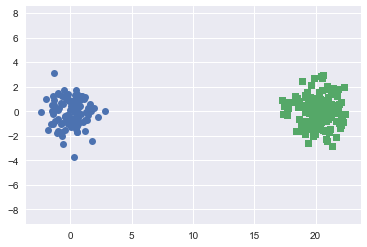

In [11]:
def galaxy(center, sigma, n):
    center = np.array(center)
    return center + sigma*np.random.randn(n, 3)

G0 = galaxy([0,0,0], 1, 100)
G1 = galaxy([20,0,0], 1, 200)
print(G0)
print(G1)

plt.plot(G0[:,0], G0[:,1], 'o')
plt.plot(G1[:,0], G1[:,1], 's')
plt.axis('equal');

We can create the dense matrix with the force from galaxy $G_1$ acting on each star in $G_0$.

In [12]:
def gravity(g0, g1):
    m = g0.shape[0]
    n = g1.shape[0]
    A = np.zeros((3*m, n))
    for i in range(m):
        r = g1.T - np.outer(g0[i,:], np.ones(n))
        A[3*i:3*i+3, :] = r / np.linalg.norm(r, axis=0)**3
    return A

A = gravity(G0, G1)

This matrix can be compressed using an SVD,
$$ U \Sigma V = A $$
where $U$ and $V^T$ have orthonormal columns and $\Sigma$ is diagonal.

array([3.5560e-01, 1.8460e-02, 1.7821e-02, 2.4281e-03, 2.5213e-04,
       2.3457e-04, 1.9308e-04, 1.8525e-04, 3.2381e-05, 5.0327e-06,
       4.0828e-06, 3.2466e-06, 3.0653e-06, 2.8117e-06, 2.7087e-06,
       4.0721e-07, 9.2210e-08, 7.6299e-08, 6.8647e-08, 5.6867e-08])

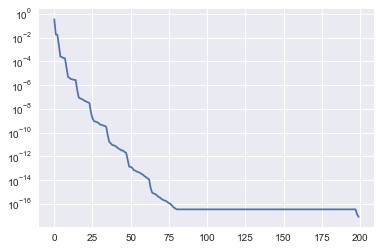

In [13]:
U, S, V = np.linalg.svd(A, full_matrices=False)
plt.semilogy(S)
S[:20]

Create a rank `k` truncated SVD
$$ \hat U \hat S \hat V \approx A $$
that approximates $A$ to a tolerance of less than $10^{-5}$.  This approximation can be applied in $O(mk + nk)$.

In [14]:
def truncate_approximation(A):
    U, S, V = np.linalg.svd(A, full_matrices=False)

    # YOUR CODE HERE
  #  raise NotImplementedError()

    #rank of truncate
    k=15     
    Uhat=U[:,:k]
    Vhat=V[:k,:]
    Shat=S[:k];
    return Uhat, Shat, Vhat



In [15]:
Uhat, Shat, Vhat = truncate_approximation(A)
assert np.linalg.norm(Uhat @ (Shat[:,None] * Vhat) - A) < 1e-5
assert len(Shat) < 20, "Your approximation is too expensive"
print('Tests pass')

Tests pass


### Experiment

Experiment with the distance between the galaxy centers and their size `sigma`.

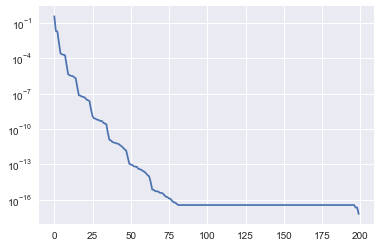

In [16]:
dist = 20
sigma = 1

A = gravity(galaxy([0,0,0], sigma, 100),
            galaxy([0,0,dist], sigma, 200))
U, S, V = np.linalg.svd(A, full_matrices=False)
plt.semilogy(S);

Explain the effect of `dist` and `sigma` on the rank `k` of the approximation necessary to attain a given tolerance.  Write your answer below.

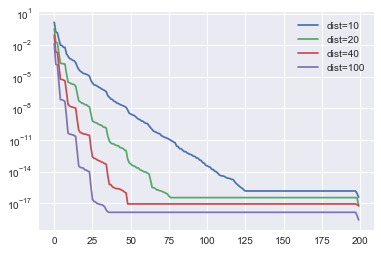

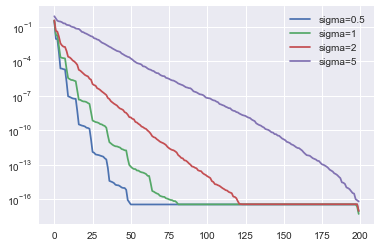

In [17]:
# Explain the effect of dist on the rank k of the approximation necessary to attain a given tolerance
 
dist = 10
sigma = 1
A = gravity(galaxy([0,0,0], sigma, 100),
            galaxy([0,0,dist], sigma, 200))
U, S1, V = np.linalg.svd(A, full_matrices=False)
dist = 20
sigma = 1
A = gravity(galaxy([0,0,0], sigma, 100),
            galaxy([0,0,dist], sigma, 200))
U, S2, V = np.linalg.svd(A, full_matrices=False)
dist = 40
sigma = 1
A = gravity(galaxy([0,0,0], sigma, 100),
            galaxy([0,0,dist], sigma, 200))
U, S3, V = np.linalg.svd(A, full_matrices=False)
dist = 100
sigma = 1
A = gravity(galaxy([0,0,0], sigma, 100),
            galaxy([0,0,dist], sigma, 200))
U, S4, V = np.linalg.svd(A, full_matrices=False)


line1, = plt.semilogy(S1)
line2, = plt.semilogy(S2)
line3, = plt.semilogy(S3)
line4, = plt.semilogy(S4)

plt.legend([line1, line2, line3, line4], ["dist=10", "dist=20", "dist=40", "dist=100"], loc=1)
plt.show()
#result analysis :the lager dist, the smaller k

# Explain the effect of sigma on the rank k of the approximation necessary to attain a given tolerance

dist = 20
sigma = 0.5
A = gravity(galaxy([0,0,0], sigma, 100),
            galaxy([0,0,dist], sigma, 200))
U, S1, V = np.linalg.svd(A, full_matrices=False)
dist = 20
sigma = 1
A = gravity(galaxy([0,0,0], sigma, 100),
            galaxy([0,0,dist], sigma, 200))
U, S2, V = np.linalg.svd(A, full_matrices=False)
dist = 20
sigma = 2
A = gravity(galaxy([0,0,0], sigma, 100),
            galaxy([0,0,dist], sigma, 200))
U, S3, V = np.linalg.svd(A, full_matrices=False)
dist = 20
sigma = 5
A = gravity(galaxy([0,0,0], sigma, 100),
            galaxy([0,0,dist], sigma, 200))
U, S4, V = np.linalg.svd(A, full_matrices=False)


line1, = plt.semilogy(S1)
line2, = plt.semilogy(S2)
line3, = plt.semilogy(S3)
line4, = plt.semilogy(S4)

plt.legend([line1, line2, line3, line4], ["sigma=0.5", "sigma=1", "sigma=2", "sigma=5"], loc=1)
plt.show()
# result analysis: the lager sigma, the lager k


